In [47]:
def undistort_img():
    # Prepare object points 0,0,0 ... 8,5,0
    obj_pts = np.zeros((6*9,3), np.float32)
    obj_pts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Stores all object points & img points from all images
    objpoints = []
    imgpoints = []

    # Get directory for all calibration images
    images = glob.glob('Curved-Lane-Lines/camera_cal/*.jpg')
    print(len(images))
    for indx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(obj_pts)
            imgpoints.append(corners)
    # Test undistortion on img
    img_size = (img.shape[1], img.shape[0])

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Save camera calibration for later use
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump( dist_pickle, open('Curved-Lane-Lines/camera_cal/cal_pickle.p', 'wb') )

def undistort(img, cal_dir='Curved-Lane-Lines/camera_cal/cal_pickle.p'):
    #cv2.imwrite('camera_cal/test_cal.jpg', dst)
    with open(cal_dir, mode='rb') as f:
        file = pickle.load(f)
    mtx = file['mtx']
    dist = file['dist']
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

In [48]:


undistort_img()



21


In [ ]:
img = cv2.imread('Curved-Lane-Lines/camera_cal/calibration1.jpg')
dst = undistort(img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [45]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

(1200, 1920, 3)


Text(0.5, 1.0, 'Undistorted Image')

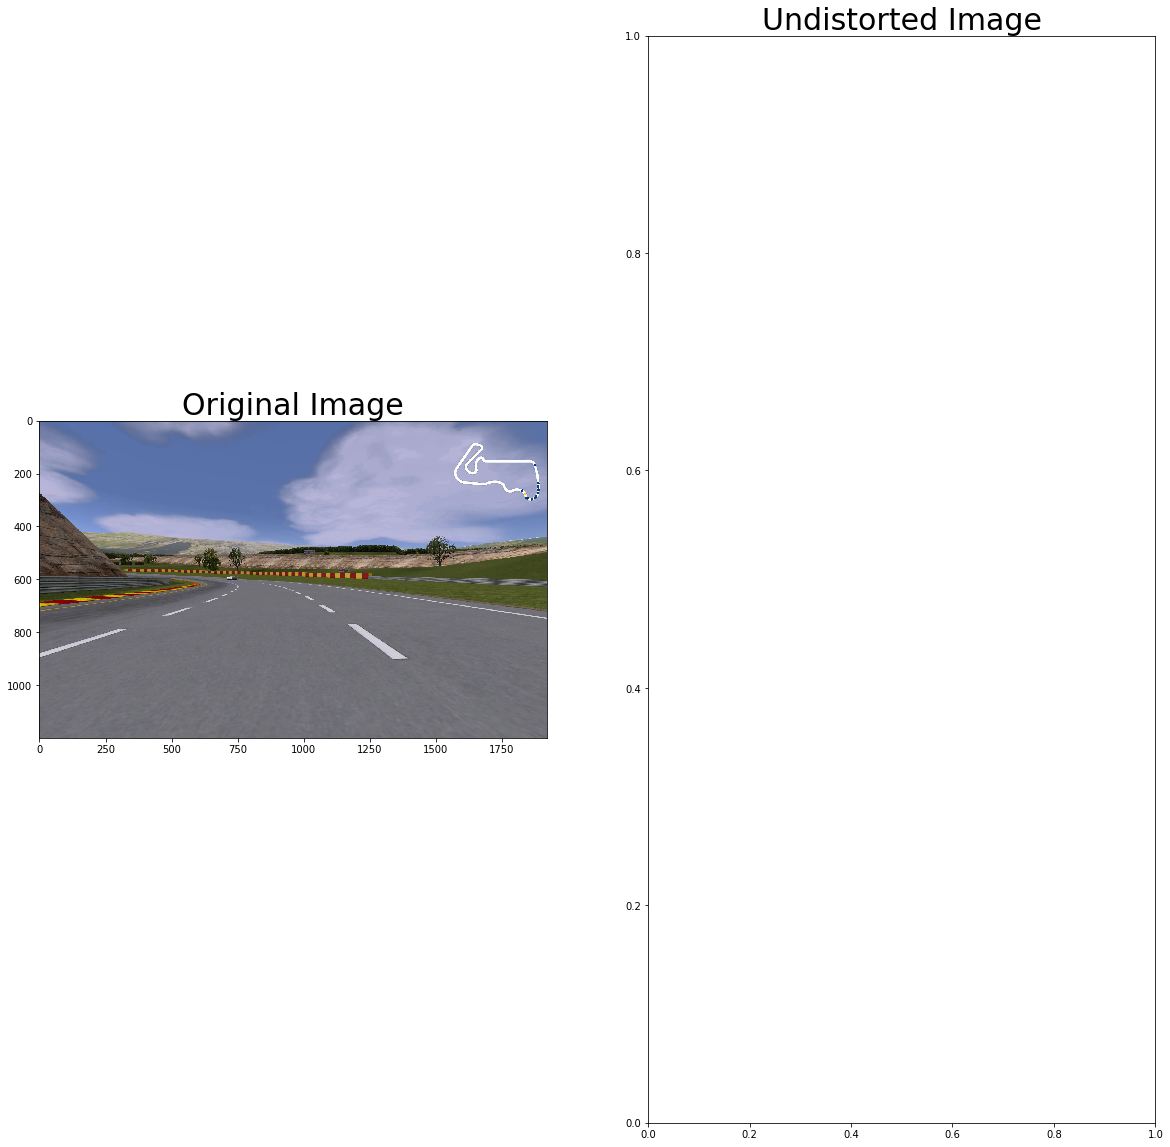

In [46]:
img = cv2.imread('Curved-Lane-Lines/test_images/image.png')
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#dst = undistort(img)


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
#ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [47]:
def pipeline(img, s_thresh=(100, 255), sx_thresh=(20, 255)):
    #img = undistort(img)
    #img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 1) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary


In [48]:
def perspective_warp(img, 
                     dst_size=(1920,1200),
                       src = np.float32([[732,618], [924, 618],  [131, 800], [1323, 800]]),
                    dst = np.float32([[0, 0],  [1920, 0],[0, 1200], [1920, 1200]])):

    img_size = np.float32([(img.shape[1],img.shape[0])])
    #src = src* img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result
    # again, not exact, but close enough for our purposes
    #dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped


In [49]:
def inv_perspective_warp(img, 
                     dst_size=(1920,1200),
                    dst = np.float32([[732,618], [924, 618],  [131, 800], [1323, 800]]),
                     src =  np.float32([[0, 0],  [1920, 0],[0, 1200], [1920, 1200]])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    #src = src* img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    #dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    print(M)
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

In [ ]:
#import numpy as np
#import cv2
#from mss import mss
#from PIL import Image

#sct = mss()

#while 1:
    #w, h = 640, 440
    #monitor = {'top': 0, 'left': 0, 'width': w, 'height': h}
    #img = Image.frombytes('RGB', (w,h), sct.grab(monitor).rgb)
    
    #dst = pipeline(np.array(img))
    #dst = perspective_warp(dst, dst_size=(640,440))
    
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    #ax1.imshow(img)
    #ax1.set_title('Original Image', fontsize=30)
    #ax2.imshow(dst, cmap='gray')
    #ax2.set_title('Warped Image', fontsize=30)
    
    #cv2.imshow('test1', dst)
    #if cv2.waitKey(25) & 0xFF == ord('q'):
        #cv2.destroyAllWindows()
        #break

/home/user1/.virtualenvs/sdc_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


KeyboardInterrupt: 

Text(0.5, 1.0, 'Warped Image')

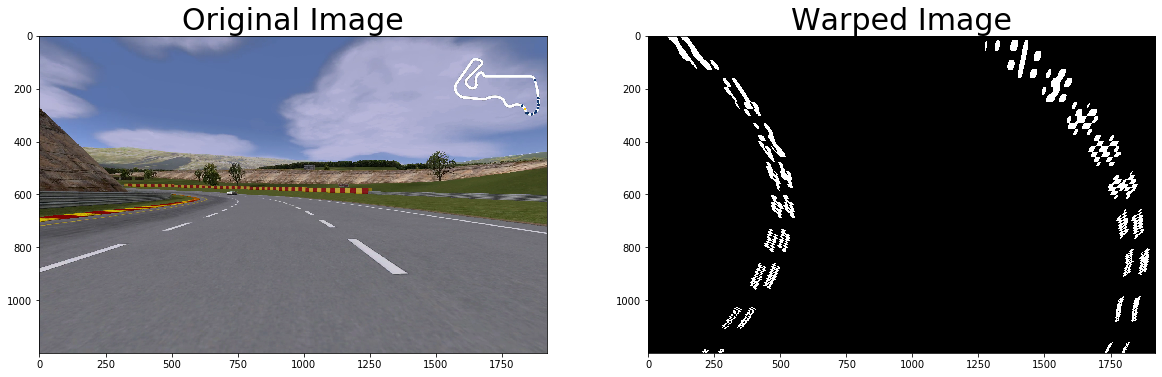

In [50]:


img = cv2.imread('Curved-Lane-Lines/test_images/image.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = pipeline(img)
dst = perspective_warp(dst, dst_size=(1920,1200))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)

In [51]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]


def sliding_window(img, nwindows=9, margin=150, minpix = 1, draw_windows=True):
    global left_a, left_b, left_c,right_a, right_b, right_c 
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    out_img = np.dstack((img, img, img))*255

    histogram = get_hist(img)
    
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (100,255,255), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (100,255,255), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        
#        if len(good_right_inds) > minpix:        
#            rightx_current = np.int(np.mean([leftx_current +900, np.mean(nonzerox[good_right_inds])]))
#        elif len(good_left_inds) > minpix:
#            rightx_current = np.int(np.mean([np.mean(nonzerox[good_left_inds]) +900, rightx_current]))
#        if len(good_left_inds) > minpix:
#            leftx_current = np.int(np.mean([rightx_current -900, np.mean(nonzerox[good_left_inds])]))
#        elif len(good_right_inds) > minpix:
#            leftx_current = np.int(np.mean([np.mean(nonzerox[good_right_inds]) -900, leftx_current]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

def get_curve(img, leftx, rightx):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    car_pos = img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

def draw_lanes(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))
    
    cv2.fillPoly(color_img, np.int_(points), (0,200,255))
    print('color image')
    plt.imshow(color_img)
    inv_perspective = inv_perspective_warp(color_img)
    print('inverse image')
    plt.imshow(inv_perspective)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective

(2, 1200)
after curve
[119.28619676 120.49213804 121.69621661 ... 229.46955114 228.44584634
 227.42027885]
[1357.81791107 1358.93958405 1360.05995152 ... 1765.96774501 1765.52672113
 1765.08439174]
color image
[[ 1.00000000e-01 -5.92416107e-01  7.32000000e+02]
 [ 0.00000000e+00 -4.07617450e-01  6.18000000e+02]
 [-0.00000000e+00 -6.99105145e-04  1.00000000e+00]]
inverse image
after draw lines


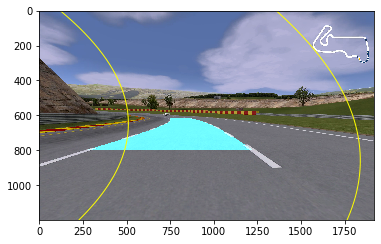

In [52]:
#%matplotlib gtk
out_img, curves, lanes, ploty = sliding_window(dst)
plt.imshow(out_img)
plt.plot(curves[0], ploty, color='yellow', linewidth=1)
plt.plot(curves[1], ploty, color='yellow', linewidth=1)
print(np.asarray(curves).shape)
curverad=get_curve(img, curves[0],curves[1])
print('after curve')
print(curves[0])
print(curves[1])
img_ = draw_lanes(img, curves[0], curves[1])
print('after draw lines')
plt.imshow(img_, cmap='hsv')

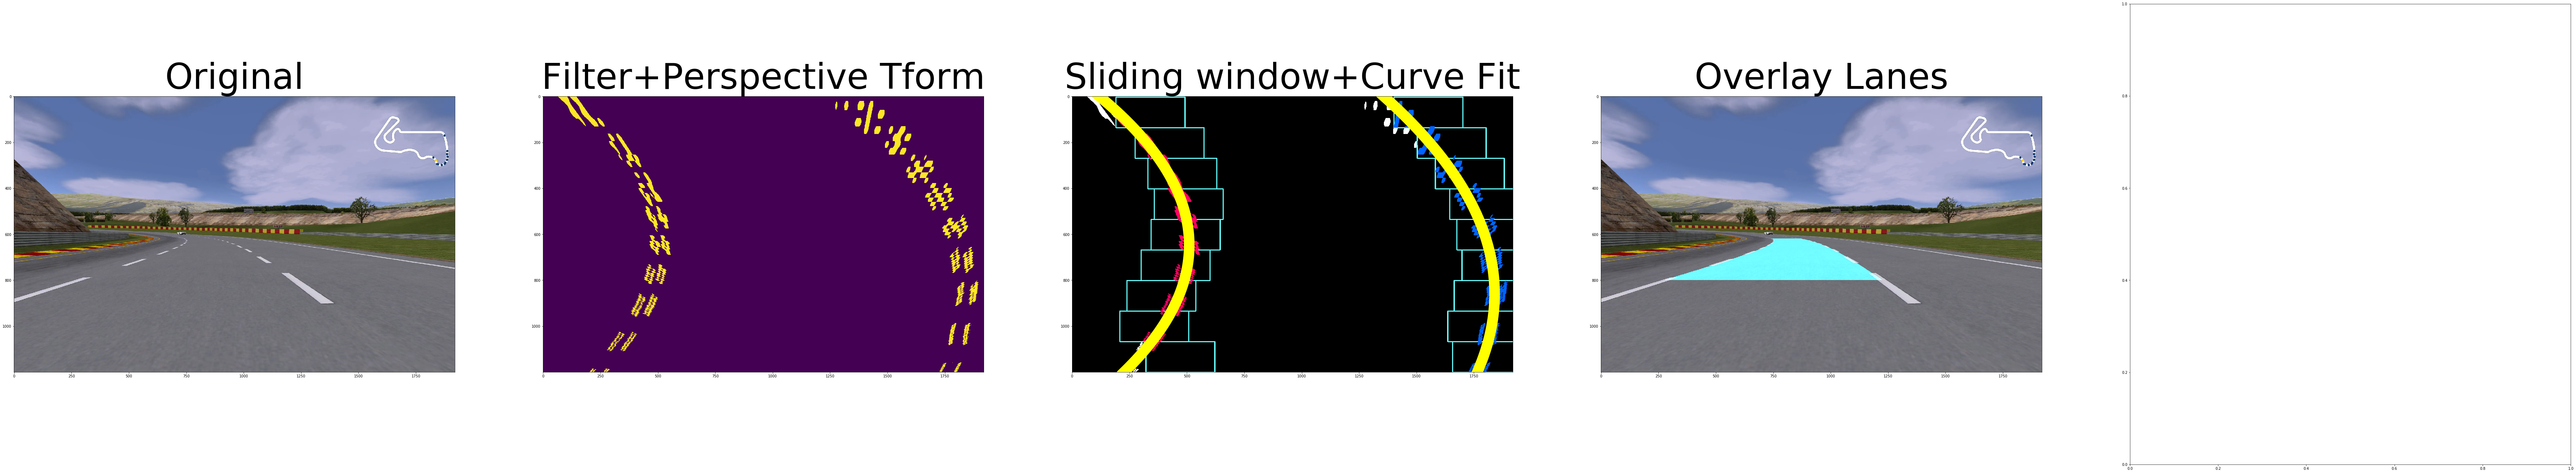

In [53]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(100, 20))
#f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=100)
ax2.imshow(dst)
ax2.set_title('Filter+Perspective Tform', fontsize=100)
ax3.imshow(out_img)
ax3.plot(curves[0], ploty, color='yellow', linewidth=30)
ax3.plot(curves[1], ploty, color='yellow', linewidth=30)
ax3.set_title('Sliding window+Curve Fit', fontsize=100)
ax4.imshow(img_)

ax4.set_title('Overlay Lanes', fontsize=100)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   0%|          | 0/2701 [00:00<?, ?it/s, now=None]

Moviepy - Building video /home/user1/Desktop/laneoutput.mp4.
Moviepy - Writing video /home/user1/Desktop/laneoutput.mp4

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image


t:   0%|          | 2/2701 [00:00<08:08,  5.53it/s, now=None]

[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image
[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   0%|          | 3/2701 [00:00<10:28,  4.29it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   0%|          | 4/2701 [00:01<11:59,  3.75it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   0%|          | 5/2701 [00:01<13:06,  3.43it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   0%|          | 6/2701 [00:01<14:14,  3.15it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   0%|          | 7/2701 [00:02<15:11,  2.95it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   0%|          | 8/2701 [00:02<16:03,  2.80it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   0%|          | 9/2701 [00:02<16:24,  2.73it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   0%|          | 10/2701 [00:03<16:24,  2.73it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   0%|          | 11/2701 [00:03<16:32,  2.71it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   0%|          | 12/2701 [00:04<16:15,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   0%|          | 13/2701 [00:04<16:07,  2.78it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 14/2701 [00:04<16:05,  2.78it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 15/2701 [00:05<15:57,  2.81it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 16/2701 [00:05<15:58,  2.80it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 17/2701 [00:05<16:03,  2.79it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 18/2701 [00:06<15:58,  2.80it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 19/2701 [00:06<15:55,  2.81it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 20/2701 [00:06<16:05,  2.78it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 21/2701 [00:07<15:59,  2.79it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 22/2701 [00:07<16:00,  2.79it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 23/2701 [00:07<15:56,  2.80it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 24/2701 [00:08<16:04,  2.78it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 25/2701 [00:08<16:03,  2.78it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 26/2701 [00:09<16:08,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 27/2701 [00:09<16:07,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 28/2701 [00:09<16:12,  2.75it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 29/2701 [00:10<16:11,  2.75it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 30/2701 [00:10<16:09,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 31/2701 [00:10<16:06,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 32/2701 [00:11<16:15,  2.74it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|          | 33/2701 [00:11<16:08,  2.75it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|▏         | 34/2701 [00:11<16:07,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|▏         | 35/2701 [00:12<16:04,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|▏         | 36/2701 [00:12<16:07,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|▏         | 37/2701 [00:13<16:07,  2.75it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|▏         | 38/2701 [00:13<16:14,  2.73it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|▏         | 39/2701 [00:13<16:10,  2.74it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   1%|▏         | 40/2701 [00:14<16:18,  2.72it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 41/2701 [00:14<16:12,  2.74it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 42/2701 [00:14<16:05,  2.75it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 43/2701 [00:15<16:03,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 44/2701 [00:15<16:20,  2.71it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 45/2701 [00:16<16:22,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 46/2701 [00:16<16:21,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 47/2701 [00:16<16:16,  2.72it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 48/2701 [00:17<16:22,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 49/2701 [00:17<16:27,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 50/2701 [00:17<16:39,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 51/2701 [00:18<16:36,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 52/2701 [00:18<16:35,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 53/2701 [00:19<16:40,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 54/2701 [00:19<16:35,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 55/2701 [00:19<16:39,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 56/2701 [00:20<16:32,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 57/2701 [00:20<16:36,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 58/2701 [00:20<16:35,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 59/2701 [00:21<16:26,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 60/2701 [00:21<16:24,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 61/2701 [00:22<16:37,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 62/2701 [00:22<16:35,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 63/2701 [00:22<16:32,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 64/2701 [00:23<16:33,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 65/2701 [00:23<16:30,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 66/2701 [00:23<16:30,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   2%|▏         | 67/2701 [00:24<16:31,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 68/2701 [00:24<16:29,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 69/2701 [00:25<16:32,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 70/2701 [00:25<16:32,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 71/2701 [00:25<16:27,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 72/2701 [00:26<16:34,  2.64it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 73/2701 [00:26<16:52,  2.60it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 74/2701 [00:26<16:44,  2.62it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 75/2701 [00:27<16:37,  2.63it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 76/2701 [00:27<16:33,  2.64it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 77/2701 [00:28<16:39,  2.63it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 78/2701 [00:28<16:37,  2.63it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 79/2701 [00:28<16:28,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 80/2701 [00:29<16:24,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 81/2701 [00:29<16:30,  2.64it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 82/2701 [00:29<16:25,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 83/2701 [00:30<16:21,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 84/2701 [00:30<16:21,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 85/2701 [00:31<16:20,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 86/2701 [00:31<16:18,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 87/2701 [00:31<16:13,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 88/2701 [00:32<16:08,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 89/2701 [00:32<16:13,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 90/2701 [00:32<16:14,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 91/2701 [00:33<16:08,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 92/2701 [00:33<16:10,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 93/2701 [00:34<16:14,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   3%|▎         | 94/2701 [00:34<16:06,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▎         | 95/2701 [00:34<16:02,  2.71it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▎         | 96/2701 [00:35<16:05,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▎         | 97/2701 [00:35<15:59,  2.71it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▎         | 98/2701 [00:35<15:54,  2.73it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▎         | 99/2701 [00:36<15:56,  2.72it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▎         | 100/2701 [00:36<15:56,  2.72it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▎         | 101/2701 [00:36<15:54,  2.72it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 102/2701 [00:37<16:02,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 103/2701 [00:37<15:57,  2.71it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 104/2701 [00:38<15:57,  2.71it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 105/2701 [00:38<15:58,  2.71it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 106/2701 [00:38<15:55,  2.72it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 107/2701 [00:39<15:47,  2.74it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 108/2701 [00:39<15:54,  2.72it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 109/2701 [00:39<15:53,  2.72it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 110/2701 [00:40<15:50,  2.73it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 111/2701 [00:40<15:51,  2.72it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 112/2701 [00:41<15:49,  2.73it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 113/2701 [00:41<15:52,  2.72it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 114/2701 [00:41<16:00,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 115/2701 [00:42<16:02,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 116/2701 [00:42<16:00,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 117/2701 [00:42<15:59,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 118/2701 [00:43<15:54,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 119/2701 [00:43<16:01,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 120/2701 [00:44<15:59,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   4%|▍         | 121/2701 [00:44<15:58,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 122/2701 [00:44<16:00,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 123/2701 [00:45<15:59,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 124/2701 [00:45<15:58,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 125/2701 [00:45<15:53,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 126/2701 [00:46<15:52,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 127/2701 [00:46<15:59,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 128/2701 [00:46<16:00,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 129/2701 [00:47<15:55,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 130/2701 [00:47<16:04,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 131/2701 [00:48<16:10,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 132/2701 [00:48<15:57,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 133/2701 [00:48<15:54,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 134/2701 [00:49<15:55,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▍         | 135/2701 [00:49<15:52,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▌         | 136/2701 [00:49<15:47,  2.71it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▌         | 137/2701 [00:50<15:48,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▌         | 138/2701 [00:50<15:52,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▌         | 139/2701 [00:51<15:48,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▌         | 140/2701 [00:51<15:48,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▌         | 141/2701 [00:51<15:49,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▌         | 142/2701 [00:52<15:46,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▌         | 143/2701 [00:52<15:53,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▌         | 144/2701 [00:52<15:48,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▌         | 145/2701 [00:53<15:43,  2.71it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▌         | 146/2701 [00:53<15:52,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▌         | 147/2701 [00:54<15:49,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   5%|▌         | 148/2701 [00:54<15:46,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 149/2701 [00:54<15:56,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 150/2701 [00:55<15:56,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 151/2701 [00:55<15:58,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 152/2701 [00:55<15:55,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 153/2701 [00:56<15:54,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 154/2701 [00:56<15:52,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 155/2701 [00:57<15:55,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 156/2701 [00:57<16:00,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 157/2701 [00:57<16:05,  2.63it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 158/2701 [00:58<16:16,  2.60it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 159/2701 [00:58<16:20,  2.59it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 160/2701 [00:58<16:17,  2.60it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 161/2701 [00:59<16:10,  2.62it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 162/2701 [00:59<16:17,  2.60it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 163/2701 [01:00<16:16,  2.60it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 164/2701 [01:00<16:06,  2.62it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 165/2701 [01:00<16:01,  2.64it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 166/2701 [01:01<16:06,  2.62it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 167/2701 [01:01<16:02,  2.63it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▌         | 168/2701 [01:02<15:56,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▋         | 169/2701 [01:02<15:51,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▋         | 170/2701 [01:02<15:51,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▋         | 171/2701 [01:03<15:46,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▋         | 172/2701 [01:03<15:48,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▋         | 173/2701 [01:03<15:43,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▋         | 174/2701 [01:04<15:53,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   6%|▋         | 175/2701 [01:04<15:56,  2.64it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 176/2701 [01:05<15:53,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 177/2701 [01:05<15:48,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 178/2701 [01:05<15:56,  2.64it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 179/2701 [01:06<16:01,  2.62it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 180/2701 [01:06<15:56,  2.64it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 181/2701 [01:06<15:50,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 182/2701 [01:07<15:52,  2.64it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 183/2701 [01:07<15:53,  2.64it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 184/2701 [01:08<15:51,  2.65it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 185/2701 [01:08<15:38,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 186/2701 [01:08<15:42,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 187/2701 [01:09<15:43,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 188/2701 [01:09<15:39,  2.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 189/2701 [01:09<15:44,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 190/2701 [01:10<15:42,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 191/2701 [01:10<15:50,  2.64it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 192/2701 [01:11<15:59,  2.62it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 193/2701 [01:11<16:07,  2.59it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 194/2701 [01:11<16:21,  2.55it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 195/2701 [01:12<16:27,  2.54it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 196/2701 [01:12<16:27,  2.54it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 197/2701 [01:13<16:32,  2.52it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 198/2701 [01:13<16:48,  2.48it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 199/2701 [01:13<16:50,  2.48it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 200/2701 [01:14<16:56,  2.46it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 201/2701 [01:14<16:56,  2.46it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   7%|▋         | 202/2701 [01:15<17:00,  2.45it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 203/2701 [01:15<17:03,  2.44it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 204/2701 [01:15<17:01,  2.44it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 205/2701 [01:16<17:01,  2.44it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 206/2701 [01:16<16:56,  2.46it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 207/2701 [01:17<16:59,  2.45it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 208/2701 [01:17<16:51,  2.46it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 209/2701 [01:17<16:49,  2.47it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 210/2701 [01:18<16:40,  2.49it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 211/2701 [01:18<16:40,  2.49it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 212/2701 [01:19<16:32,  2.51it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 213/2701 [01:19<16:42,  2.48it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 214/2701 [01:19<16:45,  2.47it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]


t:   8%|▊         | 215/2701 [01:20<17:37,  2.35it/s, now=None]

inverse image
[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 216/2701 [01:20<17:30,  2.36it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 217/2701 [01:21<17:25,  2.37it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 218/2701 [01:21<17:37,  2.35it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 219/2701 [01:22<17:24,  2.38it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 220/2701 [01:22<17:10,  2.41it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 221/2701 [01:22<17:01,  2.43it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 222/2701 [01:23<17:01,  2.43it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 223/2701 [01:23<16:47,  2.46it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 224/2701 [01:24<16:38,  2.48it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 225/2701 [01:24<16:29,  2.50it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image


t:   8%|▊         | 226/2701 [01:24<17:15,  2.39it/s, now=None]

[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image
[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 227/2701 [01:25<17:00,  2.42it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 228/2701 [01:25<16:55,  2.43it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   8%|▊         | 229/2701 [01:26<16:48,  2.45it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▊         | 230/2701 [01:26<16:41,  2.47it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▊         | 231/2701 [01:26<16:32,  2.49it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▊         | 232/2701 [01:27<16:22,  2.51it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▊         | 233/2701 [01:27<16:27,  2.50it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▊         | 234/2701 [01:28<16:24,  2.51it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▊         | 235/2701 [01:28<16:18,  2.52it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▊         | 236/2701 [01:28<16:11,  2.54it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 237/2701 [01:29<16:14,  2.53it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 238/2701 [01:29<16:21,  2.51it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 239/2701 [01:30<16:23,  2.50it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 240/2701 [01:30<16:14,  2.53it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 241/2701 [01:30<16:19,  2.51it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 242/2701 [01:31<16:25,  2.50it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 243/2701 [01:31<16:18,  2.51it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 244/2701 [01:32<16:18,  2.51it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 245/2701 [01:32<16:11,  2.53it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 246/2701 [01:32<16:11,  2.53it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 247/2701 [01:33<16:05,  2.54it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]


t:   9%|▉         | 248/2701 [01:33<16:41,  2.45it/s, now=None]

inverse image
[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 249/2701 [01:34<16:42,  2.45it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 250/2701 [01:34<16:31,  2.47it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 251/2701 [01:34<16:25,  2.49it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 252/2701 [01:35<16:19,  2.50it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 253/2701 [01:35<16:28,  2.48it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 254/2701 [01:36<16:29,  2.47it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 255/2701 [01:36<16:26,  2.48it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:   9%|▉         | 256/2701 [01:36<16:18,  2.50it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 257/2701 [01:37<16:24,  2.48it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 258/2701 [01:37<16:24,  2.48it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 259/2701 [01:38<16:19,  2.49it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 260/2701 [01:38<16:25,  2.48it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 261/2701 [01:39<16:34,  2.45it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 262/2701 [01:39<16:29,  2.46it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 263/2701 [01:39<16:22,  2.48it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 264/2701 [01:40<16:15,  2.50it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 265/2701 [01:40<16:17,  2.49it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 266/2701 [01:41<16:19,  2.49it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 267/2701 [01:41<16:13,  2.50it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 268/2701 [01:41<16:12,  2.50it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 269/2701 [01:42<16:08,  2.51it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|▉         | 270/2701 [01:42<16:09,  2.51it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|█         | 271/2701 [01:43<16:07,  2.51it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|█         | 272/2701 [01:43<16:06,  2.51it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|█         | 273/2701 [01:43<15:58,  2.53it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|█         | 274/2701 [01:44<15:54,  2.54it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|█         | 275/2701 [01:44<15:51,  2.55it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|█         | 276/2701 [01:44<15:58,  2.53it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|█         | 277/2701 [01:45<16:02,  2.52it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|█         | 278/2701 [01:45<15:58,  2.53it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|█         | 279/2701 [01:46<15:54,  2.54it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|█         | 280/2701 [01:46<15:44,  2.56it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|█         | 281/2701 [01:46<15:39,  2.58it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|█         | 282/2701 [01:47<15:39,  2.57it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  10%|█         | 283/2701 [01:47<15:38,  2.58it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 284/2701 [01:48<15:30,  2.60it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 285/2701 [01:48<15:30,  2.60it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 286/2701 [01:48<15:27,  2.61it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 287/2701 [01:49<15:22,  2.62it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 288/2701 [01:49<15:23,  2.61it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 289/2701 [01:49<15:26,  2.60it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 290/2701 [01:50<15:30,  2.59it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 291/2701 [01:50<15:25,  2.60it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 292/2701 [01:51<15:23,  2.61it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 293/2701 [01:51<15:34,  2.58it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 294/2701 [01:51<15:43,  2.55it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 295/2701 [01:52<16:03,  2.50it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 296/2701 [01:52<15:58,  2.51it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 297/2701 [01:53<15:52,  2.52it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 298/2701 [01:53<15:22,  2.61it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 299/2701 [01:53<15:04,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 300/2701 [01:54<14:47,  2.71it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 301/2701 [01:54<14:40,  2.73it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 302/2701 [01:54<14:34,  2.74it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█         | 303/2701 [01:55<14:33,  2.74it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█▏        | 304/2701 [01:55<14:28,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█▏        | 305/2701 [01:56<14:32,  2.75it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█▏        | 306/2701 [01:56<14:29,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█▏        | 307/2701 [01:56<14:27,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█▏        | 308/2701 [01:57<14:26,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█▏        | 309/2701 [01:57<14:31,  2.75it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  11%|█▏        | 310/2701 [01:57<14:32,  2.74it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 311/2701 [01:58<14:35,  2.73it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 312/2701 [01:58<14:57,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 313/2701 [02:32<7:00:39, 10.57s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 314/2701 [02:33<5:05:59,  7.69s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 315/2701 [02:34<3:38:21,  5.49s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 316/2701 [02:34<2:37:08,  3.95s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 317/2701 [02:35<1:54:17,  2.88s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 318/2701 [02:35<1:24:19,  2.12s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 319/2701 [02:36<1:08:10,  1.72s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 320/2701 [02:36<52:00,  1.31s/it, now=None]  

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 321/2701 [02:36<40:41,  1.03s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 322/2701 [02:37<32:43,  1.21it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 323/2701 [02:37<27:10,  1.46it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 324/2701 [02:37<23:13,  1.71it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 325/2701 [02:38<20:30,  1.93it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 326/2701 [02:38<18:36,  2.13it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 327/2701 [02:39<17:16,  2.29it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 328/2701 [02:39<16:17,  2.43it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 329/2701 [02:39<15:47,  2.50it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 330/2701 [02:40<15:23,  2.57it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 331/2701 [02:40<15:02,  2.62it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 332/2701 [02:40<15:21,  2.57it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 333/2701 [02:41<15:00,  2.63it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 334/2701 [02:41<14:51,  2.66it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 335/2701 [02:41<14:44,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 336/2701 [02:42<14:40,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  12%|█▏        | 337/2701 [02:42<14:37,  2.69it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 338/2701 [02:43<14:34,  2.70it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 339/2701 [02:43<15:24,  2.55it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 340/2701 [02:43<14:58,  2.63it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 341/2701 [02:44<14:40,  2.68it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 342/2701 [02:44<14:20,  2.74it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 343/2701 [02:44<14:14,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 344/2701 [02:45<14:04,  2.79it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 345/2701 [02:45<13:58,  2.81it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 346/2701 [02:46<13:59,  2.80it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 347/2701 [02:46<14:03,  2.79it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 348/2701 [02:46<14:09,  2.77it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 349/2701 [02:47<14:01,  2.79it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 350/2701 [02:47<13:53,  2.82it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 351/2701 [02:47<13:57,  2.81it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 352/2701 [02:48<13:56,  2.81it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 353/2701 [02:48<13:56,  2.81it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 354/2701 [02:48<13:52,  2.82it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 355/2701 [02:49<14:02,  2.78it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 356/2701 [02:49<13:59,  2.79it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 357/2701 [02:49<13:57,  2.80it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 358/2701 [02:50<13:51,  2.82it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 359/2701 [02:50<13:52,  2.81it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 360/2701 [02:51<13:52,  2.81it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 361/2701 [02:51<13:48,  2.82it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 362/2701 [02:51<14:04,  2.77it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 363/2701 [02:52<14:05,  2.76it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  13%|█▎        | 364/2701 [02:52<13:59,  2.78it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▎        | 365/2701 [02:52<13:55,  2.80it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▎        | 366/2701 [02:53<13:48,  2.82it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▎        | 367/2701 [02:53<13:52,  2.80it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▎        | 368/2701 [02:53<13:46,  2.82it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▎        | 369/2701 [02:54<13:41,  2.84it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▎        | 370/2701 [02:54<13:41,  2.84it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▎        | 371/2701 [02:54<13:47,  2.82it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 372/2701 [02:56<23:13,  1.67it/s, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]


t:  14%|█▍        | 373/2701 [02:58<40:38,  1.05s/it, now=None]

color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image
[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 374/2701 [05:11<26:25:18, 40.88s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 375/2701 [06:04<28:40:53, 44.39s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 376/2701 [06:10<21:16:00, 32.93s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 377/2701 [06:11<14:57:59, 23.18s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 378/2701 [06:11<10:32:22, 16.33s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image


t:  14%|█▍        | 379/2701 [06:12<7:32:12, 11.68s/it, now=None] 

[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image
[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 380/2701 [07:51<24:32:07, 38.06s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 381/2701 [08:09<20:35:48, 31.96s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 382/2701 [11:40<55:03:08, 85.46s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]


t:  14%|█▍        | 383/2701 [11:47<40:01:27, 62.16s/it, now=None]

inverse image
[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 384/2701 [16:10<78:45:17, 122.36s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 385/2701 [22:57<133:41:20, 207.81s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 386/2701 [24:23<110:02:42, 171.13s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 387/2701 [25:58<95:19:51, 148.31s/it, now=None] 

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 388/2701 [28:22<94:28:09, 147.03s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 389/2701 [30:32<91:06:28, 141.86s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  14%|█▍        | 390/2701 [30:51<67:24:53, 105.02s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]


t:  14%|█▍        | 391/2701 [30:55<47:54:18, 74.66s/it, now=None] 

color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image
[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  15%|█▍        | 392/2701 [31:04<35:13:34, 54.92s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  15%|█▍        | 393/2701 [31:15<26:50:21, 41.86s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  15%|█▍        | 394/2701 [31:35<22:34:48, 35.24s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  15%|█▍        | 395/2701 [31:58<20:14:46, 31.61s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  15%|█▍        | 396/2701 [32:16<17:38:09, 27.54s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  15%|█▍        | 397/2701 [34:46<41:04:15, 64.17s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


t:  15%|█▍        | 398/2701 [45:09<148:20:22, 231.88s/it, now=None]

[[-8.14977805e-01 -1.56489436e+00  1.69566063e+03]
 [-1.24651016e-01 -1.86976524e+00  1.24738272e+03]
 [-1.03017465e-04 -1.52164692e-03  1.00000000e+00]]
color image
[[ 2.13063406e-02 -7.64102556e-01  9.17000000e+02]
 [-2.89835150e-03 -4.81877270e-01  6.06000000e+02]
 [-2.21534245e-06 -8.11962973e-04  1.00000000e+00]]
inverse image


OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file /home/user1/Desktop/laneoutput.mp4:

 b''

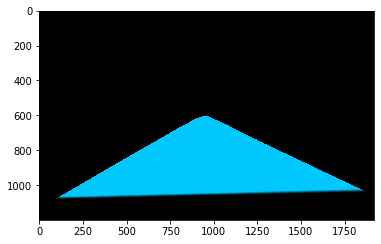

In [25]:
right_curves, left_curves = [],[]
from moviepy.editor import VideoFileClip

myclip = VideoFileClip('/home/user1/Desktop/resultingfile.mp4')#.subclip(40,43)
output_vid = '/home/user1/Desktop/laneoutput.mp4'
clip = myclip.fl_image(vid_pipeline)
clip.write_videofile(output_vid, audio=False)

In [1]:
#import numpy as np
#import cv2
#from mss import mss
#from PIL import Image

#sct = mss()

#while 1:
#    w, h = 640, 440
#    monitor = {'top': 0, 'left': 0, 'width': w, 'height': h}
#    img = Image.frombytes('RGB', (w,h), sct.grab(monitor).rgb)
#    cv2.imshow('test', np.array(img))
#    if cv2.waitKey(25) & 0xFF == ord('q'):
#        cv2.destroyAllWindows()
#        break

KeyboardInterrupt: 